In [1]:
from nht.NHT import NHT
from tensorflow import keras
import tensorflow as tf
tf.enable_eager_execution()


TensorFlow version: 1.15.0



NHT trained with: python -m nht.train_NHT --lip_coeff=0.08 --action_dim=2 --o_dim=17 --u_dim=6 --demo_save_path /uAlberta/projects/cheetah/demos/config67_run2_clipped-demo_data-10000

In [2]:
lip_coeff=0.08 
action_dim=2 
o_dim=17 
u_dim=6

In [3]:
loaded_NHT = NHT(action_dim=action_dim, output_dim=u_dim, cond_dim=o_dim, lip_coeff=lip_coeff)
loaded_h = keras.models.load_model('/home/kerrick/uAlberta/projects/NHT/test_scripts/map_model/NHT-L_0.08')
loaded_NHT.h = loaded_h





The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



2022-09-21 14:57:46.654085: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-09-21 14:57:46.677060: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 3392245000 Hz
2022-09-21 14:57:46.677313: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5627065959a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-09-21 14:57:46.677329: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


# Check L continuity of NN

In [4]:
# utils

def sample_uniform_vec(minval,maxval,shape):
    return tf.random.uniform(shape,minval=minval,maxval=maxval)

def sample_vec_batch(batch, MLP_out_dim, scale):
    return sample_uniform_vec(-scale,scale,[batch, MLP_out_dim])

In [5]:
def empirical_Lipschitz_test(n_samples, input_shape, input_scale, func):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)
        vec2 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)

        # get norm of difference
        input_diff_norm = tf.linalg.norm(vec2-vec1, axis=-1, ord=2)

        # pass through func
        out1 = func(vec1)
        out2 = func(vec2)

        output_diff_norm = tf.linalg.norm(out2-out1, axis=-1, ord=2)

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

In [6]:
BATCH_SIZE = 1
k = 2
n = 6

n_samples = 800

input_shape = [BATCH_SIZE, o_dim]

vec = sample_vec_batch(input_shape[0], input_shape[1], 1)
out = loaded_NHT.h(vec)

print(vec.shape)
print(out.shape)

assert out.shape[-1] == (n-1)*k

(1, 17)
(1, 10)


In [7]:
loaded_NHT.h.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               4608      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 72,970
Trainable params: 72,970
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import numpy as np
L_NN = loaded_NHT.L_NN
L_layer = np.power(L_NN, 1/3)

print(L_NN)
print(L_layer**3)

tf.Tensor([2.759278], shape=(1,), dtype=float32)
tf.Tensor([0.02768002], shape=(1,), dtype=float32)


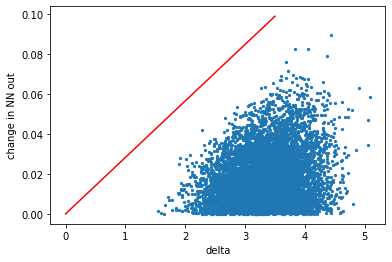

In [9]:
import matplotlib.pyplot as plt
import numpy as np

L_NN = loaded_NHT.L_NN
n_samples = 8000

BATCH_SIZE = 1
k = 2
n = 6

input_shape = [BATCH_SIZE, o_dim]

input_scale = 1

input_diff_norms, output_diff_norms = empirical_Lipschitz_test(n_samples, input_shape, input_scale, loaded_NHT.h)   

print(input_diff_norms[0])
print(output_diff_norms[0])

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('delta')
plt.ylabel('change in NN out')

x = np.linspace(0,3.5,500)
y = L_NN*x

plt.plot(x,y, color='r')

plt.show()

# Check L continuity of full NHT end-to-end

In [11]:
def NHT_Lipschitz_test(n_samples, input_shape, input_scale, model):

    input_diff_norms = []
    output_diff_norms = []

    for _ in range(n_samples):
        # sample vecs
        vec1 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)
        vec2 = sample_vec_batch(input_shape[0], input_shape[1], input_scale)
        
        # get norm of difference
        input_diff_norm = tf.linalg.norm(tf.identity(vec2)-tf.identity(vec1), axis=-1, ord=2)

        # pass through func
        out1 = model._get_map(vec1)
        out2 = model._get_map(vec2)

        output_diff_norm = tf.linalg.norm(tf.identity(out2)-tf.identity(out1), ord=2,axis=(1,2))

        # store data
        input_diff_norms.append(input_diff_norm)
        output_diff_norms.append(output_diff_norm)

    return input_diff_norms, output_diff_norms

tf.Tensor([15.074154], shape=(1,), dtype=float32)
tf.Tensor([0.03567406], shape=(1,), dtype=float32)


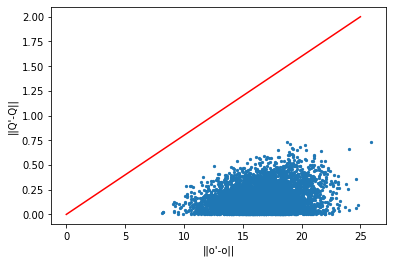

In [25]:
import matplotlib.pyplot as plt
import numpy as np

L = loaded_NHT.L
n_samples = 5000

BATCH_SIZE = 1
k = 2
n = 6

input_shape = [BATCH_SIZE, o_dim]

input_scale = 5

input_diff_norms, output_diff_norms = NHT_Lipschitz_test(n_samples, input_shape, input_scale, loaded_NHT)   

print(input_diff_norms[0])
print(output_diff_norms[0])

plt.scatter(input_diff_norms, output_diff_norms, s=5)
plt.xlabel('||o\'-o||')
plt.ylabel('||Q\'-Q||')

x = np.linspace(0,2/L,500)
y = L*x

plt.plot(x,y, color='r')

plt.show()

# Compare to model trained with L=10

In [18]:
L10_NHT = NHT(action_dim=action_dim, output_dim=u_dim, cond_dim=o_dim, lip_coeff=10)
L10_h = keras.models.load_model('/home/kerrick/uAlberta/projects/NHT/test_scripts/map_model/NHT-L_10')
L10_NHT.h = L10_h

In [26]:
L10_input_diff_norms, L10_output_diff_norms = NHT_Lipschitz_test(n_samples, input_shape, input_scale, L10_NHT)   

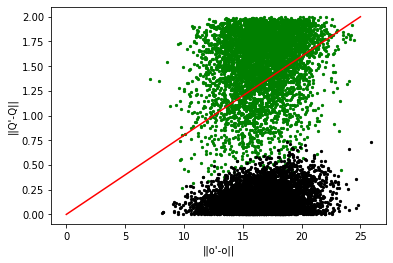

In [30]:
plt.scatter(L10_input_diff_norms, L10_output_diff_norms, s=5, color='g')
plt.scatter(input_diff_norms, output_diff_norms, s=5, color='k')

plt.xlabel('||o\'-o||')
plt.ylabel('||Q\'-Q||')

x = np.linspace(0,2/L,500)
y = L*x
plt.plot(x,y, color='r')

# x2 = np.linspace(0,2/10,500)
# y2 = 10*x2
# plt.plot(x2,y2, color='k')

plt.show()